# Candidate Screening (Get Hired) AI System  
### Course Assignment Notebook

---

## 🎯 Goal  
The objective of this notebook is to build a **minimal but complete NLP workflow** for resume screening.  
We will process a small set of candidate resumes and experiment with different text representation techniques to analyze similarity and retrieval.  

---

## 📂 Dataset  
- ~5 sample resumes in **.txt** format  

---

## ⚙️ Workflow Overview  

1. **Load Data**
   - Import and preview ~5 sample resumes  

2. **Text Preprocessing**
   - Tokenization  
   - Stopword removal  
   - Stemming  
   - Lemmatization  
   - Part-of-Speech (POS) tagging  
   - Named Entity Recognition (NER)  

3. **Document Embeddings**
   - Word2Vec **CBOW**  
   - Word2Vec **Skip-gram**  
   - **BERT** embeddings  

4. **Analysis & Visualization**
   - Compare embedding spaces  
   - Compute nearest neighbors between resumes  
   - Visualize similarities (e.g., scatter plots, clustering)  

5. **Discussion**
   - Trade-offs between CBOW, Skip-gram, and BERT  
   - Observations on resume similarity and screening  

---

## ✅ Expected Outcome  
By the end of this notebook, we will have:  
- A **pipeline** for preprocessing resumes  
- Multiple **document embeddings** for comparison  
- **Visualizations** of resume similarity  
- A discussion of **advantages and limitations** of each embedding approach


# I. Data Preprocessing

### 1) Setup

We install/import the NLP libraries and resources we need (NLTK, spaCy, Gensim, scikit-learn, etc.).We install/import the NLP libraries and resources we need (NLTK, spaCy, Gensim, scikit-learn, etc.).

In [1]:
# If you're in a fresh environment (e.g., Colab), uncomment to install:
# !pip install nltk spacy

import os, glob, re, string, pathlib
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize

import spacy

# NLTK resources (safe to run multiple times)
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

# Ensure spaCy English model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import spacy.cli
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

SEED = 42


### 2) Upload



We load a small collection of resumes in `.txt` format.  
Each resume will be treated as a document for our NLP workflow.  

This step ensures we have consistent text input before applying preprocessing techniques.


In [2]:
from google.colab import files
import io
import pandas as pd

print("Please select one or more .txt resumes")
uploaded = files.upload()   # opens the file picker

df = pd.DataFrame({
    "filename": list(uploaded.keys()),
    "text": [io.StringIO(uploaded[f].decode("utf-8", errors="ignore")).read()
             for f in uploaded]
})

print(f"✅ Loaded {len(df)} files")
df.head()


Please select one or more .txt resumes


Saving 00001.txt to 00001 (1).txt
Saving 00002.txt to 00002 (1).txt
Saving 00003.txt to 00003 (1).txt
Saving 00004.txt to 00004 (1).txt
Saving 00005.txt to 00005 (1).txt
✅ Loaded 5 files


,filename,text
0,00001 (1).txt,"Database Administrator <span class=""hl"">Databa..."
1,00002 (1).txt,"Database Administrator <span class=""hl"">Databa..."
2,00003 (1).txt,Oracle Database Administrator Oracle <span cla...
3,00004 (1).txt,Amazon Redshift Administrator and ETL Develope...
4,00005 (1).txt,Scrum Master Scrum Master Scrum Master Richmon...


### 3) Tokenization

We split raw text into individual tokens (words and punctuation).  
This converts unstructured strings into a sequence of analyzable units, which is required for cleaning, counting, and modeling.

In [3]:
import nltk
from nltk.tokenize import word_tokenize

# Make sure both pieces are present
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)   # <-- new requirement in newer NLTK

df["tokens"] = df["text"].apply(word_tokenize)
df[["filename", "tokens"]].head()


,filename,tokens
0,00001 (1).txt,"[Database, Administrator, <, span, class=, '',..."
1,00002 (1).txt,"[Database, Administrator, <, span, class=, '',..."
2,00003 (1).txt,"[Oracle, Database, Administrator, Oracle, <, s..."
3,00004 (1).txt,"[Amazon, Redshift, Administrator, and, ETL, De..."
4,00005 (1).txt,"[Scrum, Master, Scrum, Master, Scrum, Master, ..."


### 4) Cleaning

We normalize the tokens by lowercasing, removing URLs, emails, numbers/punctuation-only tokens, and common stopwords.  
The goal is to drop noise and keep only meaningful words so later features reflect content rather than formatting artifacts.

In [4]:
import re, string
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)

stop_words = set(stopwords.words("english"))
punct = set(string.punctuation)
URL_RE = re.compile(r"https?://\S+|www\.\S+")
EMAIL_RE = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")

def clean_tokens(tokens):
    cleaned = []
    for t in tokens:
        t = t.lower()
        if URL_RE.match(t) or EMAIL_RE.match(t):
            continue
        if t.isalpha() and t not in stop_words and t not in punct:
            cleaned.append(t)
    return cleaned

df["clean_tokens"] = df["tokens"].apply(clean_tokens)
df[["filename", "clean_tokens"]].head()


,filename,clean_tokens
0,00001 (1).txt,"[database, administrator, span, hl, database, ..."
1,00002 (1).txt,"[database, administrator, span, hl, database, ..."
2,00003 (1).txt,"[oracle, database, administrator, oracle, span..."
3,00004 (1).txt,"[amazon, redshift, administrator, etl, develop..."
4,00005 (1).txt,"[scrum, master, scrum, master, scrum, master, ..."


### 5) Stemming


We reduce words to crude roots.
This collapses inflected forms into a shared surface, helping counts and simple models treat similar words as the same signal.

In [5]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
df["stemmed_tokens"] = df["clean_tokens"].apply(
    lambda toks: [stemmer.stem(t) for t in toks]
)
df[["filename", "stemmed_tokens"]].head()


,filename,stemmed_tokens
0,00001 (1).txt,"[databas, administr, span, hl, databas, span, ..."
1,00002 (1).txt,"[databas, administr, span, hl, databas, span, ..."
2,00003 (1).txt,"[oracl, databas, administr, oracl, span, hl, d..."
3,00004 (1).txt,"[amazon, redshift, administr, etl, develop, bu..."
4,00005 (1).txt,"[scrum, master, scrum, master, scrum, master, ..."


### 6) Lemmatization


We convert words to their proper dictionary base forms using linguistic rules.
Compared to stemming, lemmatization is cleaner and keeps valid words, improving readability and downstream features.



In [6]:
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

lemmatizer = WordNetLemmatizer()
df["lemmas"] = df["clean_tokens"].apply(
    lambda toks: [lemmatizer.lemmatize(t) for t in toks]
)
df[["filename", "lemmas"]].head()


,filename,lemmas
0,00001 (1).txt,"[database, administrator, span, hl, database, ..."
1,00002 (1).txt,"[database, administrator, span, hl, database, ..."
2,00003 (1).txt,"[oracle, database, administrator, oracle, span..."
3,00004 (1).txt,"[amazon, redshift, administrator, etl, develop..."
4,00005 (1).txt,"[scrum, master, scrum, master, scrum, master, ..."


### 7) Part-of-Speech (POS) Tagging


We label each token with its grammatical role.
These tags let us filter or weight tokens by function—for example, prioritizing nouns for skills and titles while down-weighting filler words.


In [7]:
import nltk
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("averaged_perceptron_tagger_eng", quiet=True)  # <-- new name in NLTK ≥3.8

df["pos_tags"] = df["clean_tokens"].apply(
    lambda toks: nltk.pos_tag(toks)
)
df[["filename", "pos_tags"]].head()


,filename,pos_tags
0,00001 (1).txt,"[(database, NN), (administrator, NN), (span, N..."
1,00002 (1).txt,"[(database, NN), (administrator, NN), (span, N..."
2,00003 (1).txt,"[(oracle, NN), (database, NN), (administrator,..."
3,00004 (1).txt,"[(amazon, JJ), (redshift, NN), (administrator,..."
4,00005 (1).txt,"[(scrum, NN), (master, NN), (scrum, NN), (mast..."


### 8) Named Entity Recognition (NER)


We detect structured entities such as **PERSON**, **ORG**, **GPE** (locations), **DATE**, etc.  
Entities help surface key résumé signals (companies, roles, places, timelines) and make the text more informative and searchable.


In [8]:
!python -m spacy download en_core_web_sm 2>/dev/null
import spacy
from collections import defaultdict
import pandas as pd

nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    """
    Run spaCy's NER model and group entities by label.
    """
    doc = nlp(text)
    entities = defaultdict(list)
    for ent in doc.ents:
        entities[ent.label_].append(ent.text)
    return dict(entities)

df["entities"] = df["text"].apply(extract_entities)

ner_rows = []
for fname, ents in zip(df["filename"], df["entities"]):
    for label, items in ents.items():
        for item in items:
            ner_rows.append([fname, label, item])

ner_df = pd.DataFrame(ner_rows, columns=["filename", "entity_type", "entity_text"])

print("Sample extracted entities:")
ner_df.head(20)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Sample extracted entities:


,filename,entity_type,entity_text
0,00001 (1).txt,ORG,> Database Administrator - Family Private Care...
1,00001 (1).txt,ORG,SQL Server
2,00001 (1).txt,ORG,SSIS
3,00001 (1).txt,ORG,OLTP
4,00001 (1).txt,ORG,Log Shipping
5,00001 (1).txt,ORG,CDP
6,00001 (1).txt,ORG,Review Procedures
7,00001 (1).txt,ORG,Validate
8,00001 (1).txt,ORG,SSRS
9,00001 (1).txt,ORG,SQL Server


## II. Embedding


In [9]:
df["clean_text"] = df["clean_tokens"].apply(lambda toks: " ".join(toks))

### 1) Continuous Bag-of-Words (CBOW)


In [10]:
pip install gensim

We train a Word2Vec model with the **CBOW** setting (`sg=0`).  
CBOW learns to predict a word from the surrounding context, then averages the vectors of all words in each document to form a single 100-dimensional résumé embedding.  
This produces a lightweight representation that captures overall vocabulary usage and is fast to compute.

In [11]:
from gensim.models import Word2Vec
import numpy as np

cbow_model = Word2Vec(
    sentences=df["clean_tokens"],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=0  # CBOW
)

def doc_vector_cbow(tokens):
    vectors = [cbow_model.wv[w] for w in tokens if w in cbow_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(cbow_model.vector_size)

df["emb_cbow"] = df["clean_tokens"].apply(doc_vector_cbow)
print("CBOW embedding shape:", df["emb_cbow"][0].shape)


CBOW embedding shape: (100,)


### 2) Skip-gram


Next we train another Word2Vec model but with **Skip-gram** (`sg=1`).  
Skip-gram predicts context words from each target word, which helps it learn good vectors for less frequent or more specialized terms.  
Document embeddings are again obtained by averaging the word vectors, giving a 100-dimensional representation that can capture rare, domain-specific skills.

In [12]:
from gensim.models import Word2Vec
import numpy as np

skipgram_model = Word2Vec(
    sentences=df["clean_tokens"],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # Skip-gram
)

def doc_vector_skip(tokens):
    vectors = [skipgram_model.wv[w] for w in tokens if w in skipgram_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(skipgram_model.vector_size)

df["emb_skipgram"] = df["clean_tokens"].apply(doc_vector_skip)
print("Skip-gram embedding shape:", df["emb_skipgram"][0].shape)


Skip-gram embedding shape: (100,)


### 3) BERT


Finally we generate contextual embeddings with **BERT (bert-base-uncased)**.  
Instead of predicting nearby words, BERT uses a deep transformer network to encode the entire sentence at once.  
We mean-pool its last hidden states to produce a ~768-dimensional vector per résumé, which captures richer semantics, including word meaning that depends on context.

In [13]:
!pip install -q transformers torch

import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

def bert_sentence_embedding(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        outputs = bert_model(**inputs)
        # mean pooling over the sequence dimension
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.numpy()

df["emb_bert"] = df["clean_text"].apply(bert_sentence_embedding)
print("BERT embedding shape:", df["emb_bert"][0].shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT embedding shape: (768,)


### 4) Comparison and Visualization


To evaluate these embeddings, we compute pairwise **cosine similarity** to see how closely different résumés cluster.  
We also use **PCA** to reduce the high-dimensional vectors to two dimensions and plot them, making it easy to visually inspect groups of similar documents.  
This comparison highlights trade-offs between classic Word2Vec methods (fast, lightweight) and BERT (heavier but more context-aware).




emb_cbow: mean cosine similarity=0.832, std=0.090
emb_skipgram: mean cosine similarity=0.996, std=0.002
emb_bert: mean cosine similarity=0.951, std=0.029


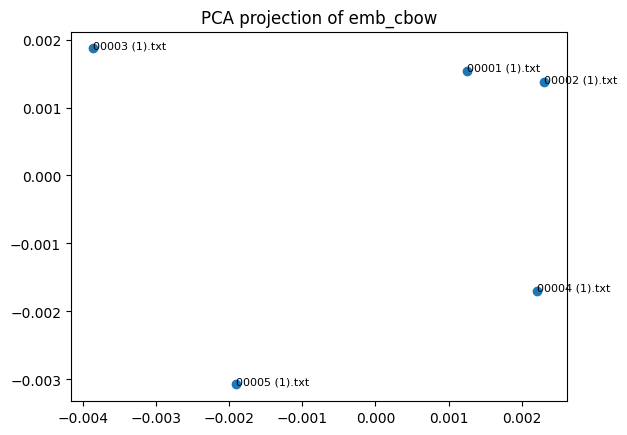

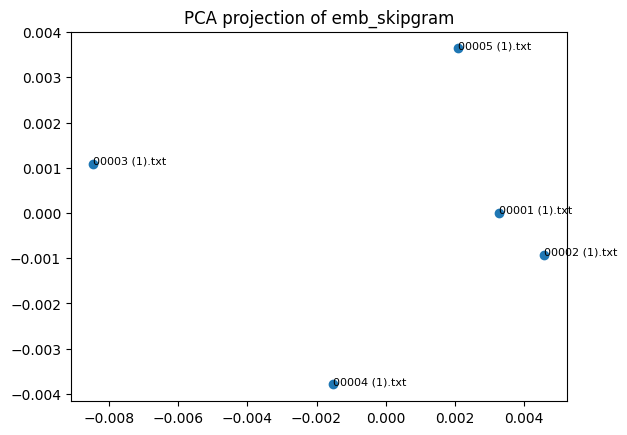

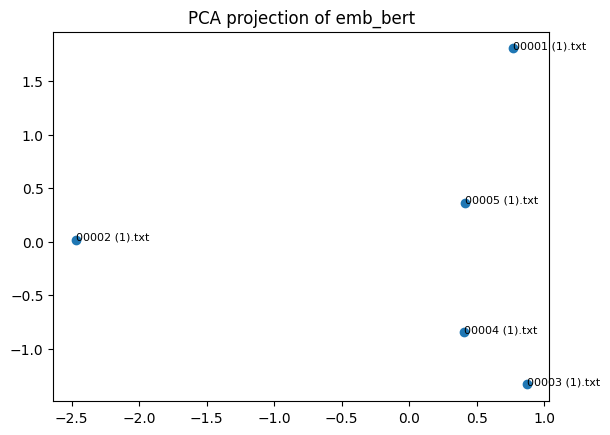

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def similarity_stats(emb_col):
    X = np.vstack(df[emb_col].values)
    sims = cosine_similarity(X)
    return sims.mean(), sims.std()

for col in ["emb_cbow", "emb_skipgram", "emb_bert"]:
    mean_sim, std_sim = similarity_stats(col)
    print(f"{col}: mean cosine similarity={mean_sim:.3f}, std={std_sim:.3f}")

for col in ["emb_cbow", "emb_skipgram", "emb_bert"]:
    X = np.vstack(df[col].values)
    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)
    plt.figure()
    plt.scatter(coords[:,0], coords[:,1])
    plt.title(f"PCA projection of {col}")
    for i, name in enumerate(df["filename"]):
        plt.text(coords[i,0], coords[i,1], name, fontsize=8)
    plt.show()


Here we apply PCA, or Principal Component Analysis, which is a dimensionality reduction technique. Since our embeddings are very high-dimensional, PCA helps us project them down into just two dimensions so we can visualize how the documents are positioned relative to each other. Looking at the plots, we see that CBOW spreads documents apart, showing coarse topical separation. Skip-gram clusters them very tightly, which reflects high similarity but may hide nuanced differences. BERT strikes a balance, grouping similar documents together while still keeping distinctions clear, thanks to its contextual understanding of language.